Load imports

In [1]:
import pandas as pd
import numpy as np
from models.gan import GAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

Load dataset

In [2]:
df_pokemon= pd.read_csv("data/Pokemon.csv")
df_pokemon.head()

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False


Preprocessing

In [3]:
df_pokemon = df_pokemon.drop(columns=['Name', 'Total', '#'], axis=1)
numerical_cols = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']
scaler = StandardScaler()
df_pokemon[numerical_cols] = scaler.fit_transform(df_pokemon[numerical_cols])
df_pokemon['Type 2'] = df_pokemon['Type 2'].fillna('None')
df_pokemon = pd.get_dummies(df_pokemon, columns=['Type 1', 'Type 2', 'Generation'])
bool_cols = df_pokemon.select_dtypes(include=['bool']).columns
df_pokemon[bool_cols] = df_pokemon[bool_cols].astype(int)
column_names = df_pokemon.columns
df_pokemon.head()

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Type 1_Bug,Type 1_Dark,Type 1_Dragon,...,Type 2_Psychic,Type 2_Rock,Type 2_Steel,Type 2_Water,Generation_1,Generation_2,Generation_3,Generation_4,Generation_5,Generation_6
0,-0.950626,-0.924906,-0.797154,-0.239130,-0.248189,-0.801503,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,-0.362822,-0.524130,-0.347917,0.219560,0.291156,-0.285015,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0.420917,0.092448,0.293849,0.831146,1.010283,0.403635,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0.420917,0.647369,1.577381,1.503891,1.729409,0.403635,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,-1.185748,-0.832419,-0.989683,-0.392027,-0.787533,-0.112853,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


Train GAN model

In [4]:
noise = np.random.normal(0, 1, df_pokemon.shape) 
gan = GAN(data=df_pokemon, noise_dim=100, epochs=10, batch_size=32)
generator = gan.create_generator()
discriminator = gan.create_discriminator()
gan_model = gan.compile(generator=generator, discriminator=discriminator)
trained_generator, d_losses, g_losses = gan.train(generator, discriminator, gan_model)

c:\Users\l.huber2\Documents\FH\2. Semester\GAI\Pokemon\venv\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
>1, d_loss=0.750, g_loss=0.733
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
>2, d_loss=0.746, g_loss=0.720
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
>3, d_loss=0.744, g_loss=0.708
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
>4, d_loss=0.741, g_loss=0.697
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
>5, d_loss=0.741, g_loss=0.687
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
>6, d_loss=0.740, g_loss=0.676
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
>7, d_loss=0.743, g_loss=0.666
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
>8, d_loss=0.743, g_loss=0.655
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
>9, d_loss=0.745, g_loss=0.645
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
>10, d_loss=0.748, g_loss=0.635


Get predicitions of GAN model

In [5]:
generate_num = 10
noise = np.random.normal(0, 1, (generate_num, 100))
predicted_data = trained_generator.predict(noise)
predicted_df = pd.DataFrame(predicted_data, columns=column_names)
predicted_df.head(10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Type 1_Bug,Type 1_Dark,Type 1_Dragon,...,Type 2_Psychic,Type 2_Rock,Type 2_Steel,Type 2_Water,Generation_1,Generation_2,Generation_3,Generation_4,Generation_5,Generation_6
0,0.552927,0.477301,0.743229,0.454943,0.404925,0.337606,0.579261,0.572236,0.318756,0.601615,...,0.607252,0.623595,0.549527,0.456102,0.445356,0.408366,0.697356,0.323516,0.592839,0.319560
1,0.568925,0.524617,0.628394,0.411724,0.272102,0.205104,0.564471,0.624663,0.378808,0.484100,...,0.503821,0.346948,0.601208,0.587977,0.184084,0.375406,0.661621,0.536723,0.642564,0.357965
2,0.495099,0.558629,0.834407,0.366450,0.298820,0.245951,0.528904,0.761232,0.256787,0.648472,...,0.512430,0.701921,0.574759,0.447270,0.212745,0.541890,0.875397,0.365316,0.641687,0.241136
3,0.545749,0.348408,0.840561,0.494584,0.367604,0.317549,0.681304,0.544420,0.384519,0.452853,...,0.639017,0.489797,0.648489,0.526631,0.182579,0.475234,0.677736,0.276981,0.641832,0.231091
4,0.507899,0.635774,0.734533,0.309921,0.340854,0.342602,0.678161,0.636502,0.312483,0.469830,...,0.507829,0.600867,0.343513,0.436667,0.261995,0.484658,0.694696,0.275381,0.617690,0.380868
5,0.472734,0.548047,0.694180,0.262987,0.456452,0.452657,0.651261,0.794799,0.394834,0.480629,...,0.552379,0.404776,0.638753,0.487129,0.253405,0.323794,0.640942,0.401349,0.582433,0.393841
6,0.538799,0.575694,0.516774,0.318009,0.421437,0.330655,0.545268,0.747037,0.441185,0.582894,...,0.528558,0.539458,0.563110,0.357127,0.237192,0.448252,0.722302,0.392593,0.489418,0.344307
7,0.487509,0.710644,0.651661,0.371022,0.471989,0.246876,0.610063,0.716418,0.219247,0.586914,...,0.431098,0.585561,0.382703,0.370873,0.308146,0.287422,0.684824,0.340600,0.455407,0.297314
8,0.569614,0.561943,0.710323,0.467242,0.444490,0.294588,0.570982,0.494538,0.290319,0.571319,...,0.478484,0.567173,0.500863,0.424782,0.373169,0.398735,0.622859,0.368138,0.612494,0.397230
9,0.489043,0.469179,0.555016,0.384155,0.396234,0.350036,0.681258,0.533075,0.445360,0.470831,...,0.538715,0.442203,0.615635,0.337928,0.189121,0.484177,0.708245,0.260185,0.529695,0.245505


Transform prediction to human readable output

In [6]:
def make_binary_attributes_readable(attributes:list) -> pd.DataFrame:
    for attribute in attributes:
        columns = [col for col in predicted_df.columns if attribute in col]

        # Get the column with the highest value for each row among 'Type 1' columns
        max = predicted_df[columns].idxmax(axis=1)

        # Extract the type name from the column names (removing the 'Type 1_' prefix)
        predicted_df[attribute[:-1]] = max.str.replace(attribute, '')

        # Optionally, you can drop the old type columns if they are no longer needed
        predicted_df.drop(columns=columns, inplace=True)
        predicted_df.head()
    return predicted_df

In [7]:
make_readble_cols= ["Generation_", "Type 1_", "Type 2_",]
readable_df = make_binary_attributes_readable(make_readble_cols)
readable_df['Legendary'] = readable_df['Legendary'] > 0.5 
readable_df[numerical_cols] = scaler.inverse_transform(readable_df[numerical_cols])
readable_df = readable_df.round(0)
readable_df.head(10)

,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Generation,Type 1,Type 2
0,83.0,94.0,97.0,88.0,83.0,78.0,True,3,Ghost,Rock
1,84.0,96.0,93.0,86.0,79.0,74.0,True,3,Flying,Flying
2,82.0,97.0,100.0,85.0,80.0,75.0,True,3,Bug,Fighting
3,83.0,90.0,100.0,89.0,82.0,77.0,True,3,Electric,Flying
4,82.0,100.0,97.0,83.0,81.0,78.0,True,3,Electric,Electric
5,81.0,97.0,95.0,81.0,85.0,81.0,True,3,Bug,Fighting
6,83.0,98.0,90.0,83.0,84.0,78.0,True,3,Bug,Flying
7,82.0,102.0,94.0,85.0,85.0,75.0,True,3,Water,Electric
8,84.0,97.0,96.0,88.0,84.0,77.0,True,3,Ghost,Electric
9,82.0,94.0,91.0,85.0,83.0,78.0,True,3,Ice,Flying


Evaluate GAN

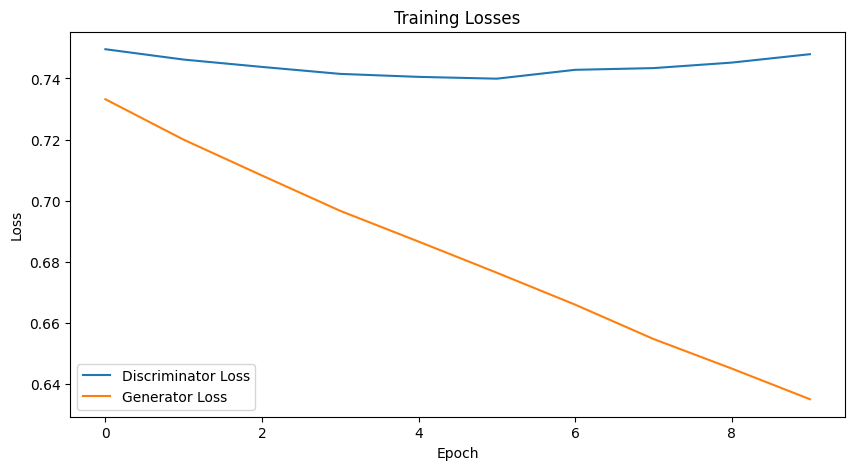

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/mnt/data/GAN_Training_Losses.png')
plt.show()

In [9]:
gan.evaluate_discriminator(generator, discriminator)

AttributeError: 'GAN' object has no attribute 'evaluate_discriminator'

Revert the values to human readable

In [ ]:
#TODO: Evaluare Model
'TODO': add total column